I wanted to introduce *partial regression plots* (or added variable plots, or predictor residual plots etc.), before moving any further down this [series](https://yigitasik.github.io/#category=Interpretability).

In the [first post of this series](https://yigitasik.github.io/posts/Interpretablog%20-%20Fire%20and%20Forget/), I showed a relationship by plotting $X_j$ vs $y$. In a multivariate setting, that doesn't tell us much since if there seems to be a relationship, it might be due to shared effects with other variables that are not $X_j$. What will we do is to plot what exactly the regression coefficient tells us: Marginal effect of $X_j$, adjusted for other variables.

Idea is pretty nice:

* We have a variable $X_j$. We fit a model to predict it with other variables.
* Residuals ($r_{Xj}$) from that model represent the part of $X_j$ that cannot be explained by other variables.
* Plot it against $y$ (or residuals of $y$).

If you're interested in the contribution of $X_j$ to prediction, after the contribution of all the other variables, you should plot against residuals of $y$.

Let's exemplify this: We are here with our good old possum data, which I used in [different](https://yigitasik.github.io/#category=Bayesian) examples as well.

In [2]:
df = pd.read_csv('possum.csv', usecols=['head_l', 'tail_l', 'total_l'])
df.head()

,head_l,total_l,tail_l
0,94.1,89.0,36.0
1,92.5,91.5,36.5
2,94.0,95.5,39.0
3,93.2,92.0,38.0
4,91.5,85.5,36.0


In [3]:
X_full = sm.add_constant(df[['head_l', 'tail_l']])
model_full = sm.OLS(df['total_l'], X_full).fit()

print('Coefficient for `head_l`: ', np.round(model_full.params['head_l'], 3))

Coefficient for `head_l`:  0.695


Here we have the full model with intercept, and note the coefficient of the head_l.

Now, I'm going to show both versions with raw values of $y$ and residuals of $y$ ($r_y$).

In [4]:
# Regressing head_l ~ tail_l

model_head_resid = LinearRegression().fit(df[['tail_l']], df['head_l'])
head_resids = df['head_l'] - model_head_resid.predict(df[['tail_l']]) # residualized head_l

In [5]:
X_v1 = sm.add_constant(head_resids) # intercept
model_v1 = sm.OLS(df['total_l'], X_v1).fit()
pred_v1 = model_v1.predict(X_v1)

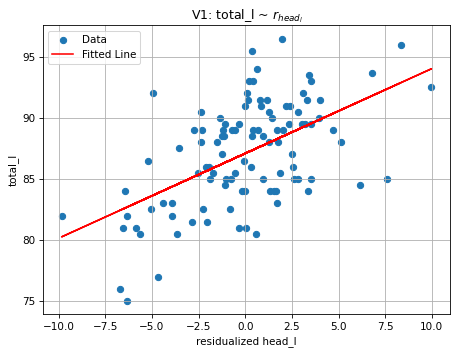

In [6]:
plt.figure(figsize=(7, 5))

plt.scatter(head_resids, df['total_l'], label='Data')
plt.plot(head_resids, pred_v1, color='red', label='Fitted Line')

plt.title('V1: total_l ~ $r_{head_l}$')

plt.xlabel('residualized head_l')
plt.ylabel('total_l')

plt.legend()
plt.grid(True)

In [7]:
model_y_resid = LinearRegression().fit(df[['tail_l']], df['total_l'])
y_resids = df['total_l'] - model_y_resid.predict(df[['tail_l']])

In [8]:
X_v2 = sm.add_constant(head_resids) # don't need it here actually, but wanted to keep things similar.

model_v2 = sm.OLS(y_resids, X_v2).fit()
pred_v2 = model_v2.predict(X_v2)

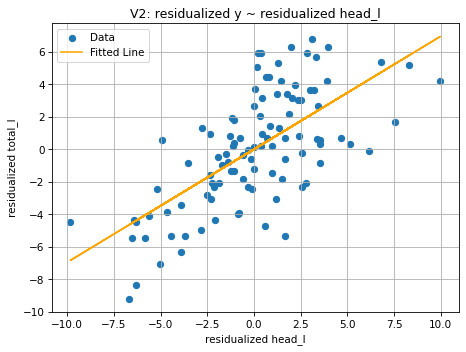

In [9]:
plt.figure(figsize=(7,5))

plt.scatter(head_resids, y_resids, label='Data')
plt.plot(head_resids, pred_v2, color='orange', label='Fitted Line')

plt.title('V2: residualized y ~ residualized head_l')

plt.xlabel('residualized head_l')
plt.ylabel('residualized total_l')

plt.legend()
plt.grid(True)

In [10]:
print('Coefficient for `head_l`: ', np.round(model_full.params['head_l'], 3))
print('Version 1 (y ~ residualized X):', np.round(model_v1.params[1], 3))
print('Version 2 (resid y ~ resid X):', np.round(model_v2.params[1], 3))

Coefficient for `head_l`:  0.695
Version 1 (y ~ residualized X): 0.695
Version 2 (resid y ~ resid X): 0.695


Which one is better?

Well, the first version is easier to interpret since `y` is in its raw. However, spread of it contains the influence of other predictors as well. Hence, although the slope reflects the contribution after knowing the others, the vertical scatter is not corresponding to the full model.

In the second one, axes are purged from the influence of other variables. So, visually, we're looking through the lens of "holding-others-constant" (literally).

This approach is beneficial for diagnostics as well, it seems to me, since:

1) It's easier to see if a particular point is pulling the slope strongly.
2) If there's high multicollinearity, $r_{X_j}$ would show a very low variance since most of it gets explained by other variables.
3) The pattern is apparent, and if it shows different kind you may think about transformations.
4) It's much easier to communicate compared to giving out the coefficient only.